# Fuzzy Clustering Experiment on Image Segmentation <br>
Antonio Raffaele Iacovazzi - Mat: 756263

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Utility

##Chuncker

In [ ]:
from PIL import Image
import numpy as np
infile = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/GF2_PMS1__L1A0001553848-MSS1_label.tif'

img = Image.open(infile)
width, height = img.size

cw= np.int(width/10)
ch = np.int(height/10)
print(cw)
print(ch)
i=0
# Save Chops of original image
for x0 in range(0, width, cw):
   for y0 in range(0, height, ch):
      box = (x0, y0,
             x0+cw if x0+cw <  width else  width - 1,
             y0+ch if y0+ch < height else height - 1)
      i=i+1
      img.crop(box).save('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/masks/'+str(i)+'_chunck.tif')

#My Fuzzy C-Means(++) code

Some hint on the implementation taken from:<br>
https://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081#:~:text=Before%20learning%20the%20details%2C%20let,to%20make%20it%20look%20different.

In [2]:
from urllib.request import DataHandler
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import kmeans_plusplus

class FCMeans:
  def __init__(self, X, num_clusters):
    self.C = num_clusters
    self.max_iter = 1000
    self.num_examples, self.num_features = X.shape
    self.m = 2 #must be in (1, +inf)
    self.epsilon = 0.01 #user defined
  
  def initialize_centroidspp (self, X):
    
    centroids = np.zeros((self.C, self.num_features))
    centroids[0] = X[np.random.choice(range(self.num_examples))] #assigning a random point in the example set as centroid
    
    for c in range(self.C-1):
      #compute distance between every point and the nearest centroid    
      centroids[c+1]  = X[np.argmax(np.min((np.sum((X[:, None, :]-centroids[None,:, :])**2, axis = 2)), axis = 1))]
         
    return centroids    

  def create_fuzzy_cluster(self, X, centroids): 
    dist_matrix  =  1/np.power((np.sum((X[:, None, :]-centroids[None,:, :])**2, axis = 2)),(1/((self.m)-1)))
    fc  = np.nan_to_num(dist_matrix/np.sum(dist_matrix, axis=1)[:, np.newaxis], nan=1)
    return fc


  def compute_new_centroids (self, X, centroids, clusters):
    centroids = np.transpose(np.dot(np.transpose(X), np.power(clusters,self.m))/np.sum(np.power(clusters,self.m),axis = 0))
    return centroids


  def compute_distance_centr(self, old_centroids, new_centroids):
    #compute norm columnwise and take the biggest
    dist= np.linalg.norm(old_centroids-new_centroids, axis=1).max()    
    return dist
  
  def execute(self, X):
    centroids,  indices = kmeans_plusplus(X, self.C, random_state=0)
    D = 100
    iter = 1
    while(D > self.epsilon and iter < self.max_iter):
      cluster = self.create_fuzzy_cluster(X, centroids)
      old_centroids = centroids.copy()
      centroids = self.compute_new_centroids(X, centroids, cluster)
      D = self.compute_distance_centr(old_centroids, centroids)
      iter = iter+1
    print("Fuzzy C Means converged in "+str(iter)+" iteration")
    pc = np.sum(np.power(cluster,2))/self.num_examples
    return cluster, old_centroids, pc


# HongLei et. al Modified Fuzzy C-Means 
In order to include spatial information in the C-Means algorithm, HongLei et. al have proposed a modified version of the fuzzy c-means which exploit Markov random field in order to establish the likelihood that a pixel can actually belong to a certain class uding the information about the class of its neighborhood pixels.<br>
This allows the algorithm to be more accurate and less sensible to the noise in the images.

In [3]:
import numpy as np
class MRFClustering:
  def __init__(self, mat, X):

    self.matrix = np.int16(mat)
    npad = ((1, 1), (1, 1), (0, 0))
    self.matrix = np.pad(self.matrix, pad_width=npad, mode='constant', constant_values=-1)

    shape = (3,3,3) #last number: dimension of the inner component
    self.neigh = np.lib.stride_tricks.sliding_window_view(self.matrix, shape)
    self.neigh = self.neigh.reshape(img.shape[0]*img.shape[1],3,3,3)
    self.neigh[:,1,1]=[-1,-1,-1] 

    self.X = X
    self.Pmat = np.zeros((mat.shape[0]*mat.shape[1],self.X.shape[0]))


  def GetScoreForCentr(self,centroid):  
    diff=(((self.neigh != centroid)&(self.neigh != [-1,-1, -1])).any(axis=3)).sum(axis=2).sum(axis=1)
    eq=((self.neigh == centroid).all(axis=3)).sum(axis=2).sum(axis=1)
    scores=diff-eq
    return scores

  def get_Px(self):
    i=0          
    for centroid in (self.X):
      self.Pmat[:,i]=self.GetScoreForCentr(centroid)
      i=i+1
    self.Pmat= np.exp(self.Pmat*(-1))    
    Z = np.reshape(np.sum(self.Pmat,axis=1), (self.Pmat.shape[0],1)) 
    Px = self.Pmat/Z
    return Px


In [4]:
from urllib.request import DataHandler
import numpy as np
import matplotlib.pyplot as plt

class ModifiedFCMeans:
  def __init__(self, X, num_clusters, centroids, result_img):
    self.C = num_clusters
    self.max_iter = 1000
    self.num_examples, self.num_features = X.shape
    self.m = 2 #must be in (1, +inf)
    self.epsilon = 0.2 #user defined
    self.centroids = centroids   
    self.result_img = result_img     

  def create_fuzzy_cluster(self, X, centroids, prob): 
    dist_matrix  =  1/(np.power((np.sum((X[:, None, :]-centroids[None,:, :])**2, axis = 2)),(1/((self.m)-1))) * np.power(prob,(1/((2)-1))) )
    fc  = np.nan_to_num(dist_matrix/np.sum(dist_matrix, axis=1)[:, np.newaxis], nan=1)
    return fc

  def compute_new_centroids (self, X, centroids, clusters, prob):
    centroids = np.transpose(np.dot(np.transpose(X), (np.power(clusters,self.m)*prob))/np.sum(np.power(clusters,self.m)*prob,axis = 0))
    return centroids

  def compute_distance_centr(self, old_centroids, new_centroids):
    #compute norm columnwise and take the biggest
    dist= np.linalg.norm(old_centroids-new_centroids, axis=1).max()    
    return dist
  
  def execute(self, X):
    D = 100
    iter = 1
    centroids = self.centroids
    center = np.uint8(centroids)
    result_image = self.result_img
    
    while(D > self.epsilon and iter < self.max_iter):
      MRF = MRFClustering(result_image,  center)
      Px = 1-MRF.get_Px()
      #print('completed pmat '+str(iter)+' times')
      cluster = self.create_fuzzy_cluster(X, centroids,Px)
      old_centroids = centroids.copy()
      centroids = self.compute_new_centroids(X, centroids, cluster, Px)
      D = self.compute_distance_centr(old_centroids, centroids)
      #print(D)
      iter = iter+1
      y_pred = cluster.argmax(axis = 1)
      center = np.uint8(centroids)
      res = center[y_pred.flatten()]
      result_image = res.reshape((result_image.shape))
      

    print("Modified Fuzzy C Means converged in "+str(iter)+" iteration")
    pc = np.sum(np.power(cluster,2))/self.num_examples
    return cluster, old_centroids, pc


# First Experiment<br>
Evaluation of the algorithm on three different subset of the Humans in the Loop - Satellite images of Dubai - UAE:<br>
https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery<br>
This dataset is often used as reference for deep leaning model like U-net.<br>
Will be interesting discover how a more simple and unsupervised algorithm behave on a dataset like this.<br>
The dataset consist of several aerial image of the Dubai territory segmeted by the semantic of the image in 6 cluster.<br>
Not all the cluster appear in all the  images.<br>
The experiment will be done using two different color space (RGB and LUA) in order to see if them have an impact on the results.


##Clusterization

In [ ]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
import sys

warnings.filterwarnings('ignore')
C = 6
orig_stdout = sys.stdout
#dim = ['small','medium','big']
dim = ['big']
for di in dim:
  path_images = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/'+di+'/images'
  images = sorted([str(f) for f in listdir(path_images) if isfile(join(path_images, f))and f.endswith('.jpg')])
  #print(images)
  l = len(images)
  for cl_space in [cv2.COLOR_BGR2RGB,cv2.COLOR_BGR2LAB]:
    if(cl_space == cv2.COLOR_BGR2RGB):
        cls = 'rgb'
    if(cl_space == cv2.COLOR_BGR2LAB):
        cls = 'lab'
    f_fcm = open('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/'+di+'/c_means_results/'+cls+''+'/'+'partition_coefficient_results_fcm.txt', 'w')
    f_mfcm = open('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/'+di+'/mod_c_means_results/'+cls+'/'+'partition_coefficient_results_mfcm.txt', 'w')
    avg_pc_fcm = 0
    avg_pc_mfcm = 0
    for i in range(l):
      #Read the image
      original_image = cv2.imread(path_images+'/'+images[i])
      img=cv2.cvtColor(original_image,cl_space)  

      #Fuzzy Clustering
      sys.stdout = f_fcm
      vectorized = np.float32(img.reshape((-1,3)))
      fc = FCMeans(vectorized, C)
      clust, centr, pc = fc.execute(vectorized)      
      avg_pc_fcm = avg_pc_fcm + pc
      print('Partition Coefficient for image '+images[i]+' '+str(pc))
      y_pred = clust.argmax(axis = 1)
      center = np.uint8(centr)
      res = center[y_pred.flatten()]
      result_image = res.reshape((img.shape))

      #Modified Fuzzy Clustering
      sys.stdout = f_mfcm
      MFCM = ModifiedFCMeans(vectorized, C, center, result_image)
      cl, cr, pc = MFCM.execute(vectorized)      
      avg_pc_mfcm = avg_pc_mfcm + pc
      print('Partition Coefficient for image '+images[i]+' '+str(pc))
      my_pred = cl.argmax(axis = 1)
      mcenter = np.uint8(cr)
      res = mcenter[my_pred.flatten()]
      result_image_mrf = res.reshape((img.shape))

      #Saving the images (FCM and MFCM)     
      cv2.imwrite('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/'+di+'/c_means_results/'+cls+'/cmeans'+str(i+1)+'.png', result_image)
      cv2.imwrite('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/'+di+'/mod_c_means_results/'+cls+'/modcmeans'+str(i+1)+'.png', result_image_mrf)
    sys.stdout = f_fcm
    avg_pc_fcm = avg_pc_fcm/l
    print('Average Partition Coefficient: '+str(avg_pc_fcm))
    sys.stdout = f_mfcm
    avg_pc_mfcm = avg_pc_mfcm/l
    print('Average Partition Coefficient: '+str(avg_pc_mfcm))
    f_fcm.close()
    f_mfcm.close()
    sys.stdout = orig_stdout

##Evaluation

In [ ]:

!pip install coclust
!pip install scikit-learn==0.22.2 #in order to use coclust for accuracy evaluation
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from scipy.optimize import linear_sum_assignment as linear_assignment
from coclust.evaluation.external import accuracy
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

orig_stdout = sys.stdout
type_res = ['c_means_results','mod_c_means_results']
dim = ['small','medium','big']
type_col = ['rgb','lab']
for t in type_res:
  for tc in type_col:
    for di in dim:
      tot_acc = 0
      tot_ars = 0
      tot_hs = 0
      tot_cs = 0
      tot_vm = 0
      tot_fms = 0
      path_images = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/'+di+'/'+t+'/'+tc
      images = sorted([str(f) for f in listdir(path_images) if isfile(join(path_images, f)) and f.endswith('.png')])
      path_masks = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/'+di+'/masks'
      masks = sorted([str(f) for f in listdir(path_masks) if isfile(join(path_masks, f))])
      l = len(images)
      f = open(path_images+'/'+'results.txt', 'w')
      sys.stdout = f
      print(images)
      for i in range(l):
        #Read the image
        result_img = cv2.imread(path_images+'/'+images[i])
        result_img=cv2.cvtColor(result_img,cv2.COLOR_BGR2GRAY)  
        labels_pred = np.squeeze(result_img.reshape((-1,1)))

        #Read the ground truth
        gt_img = cv2.imread(path_masks+'/'+masks[i])
        gt_img=cv2.cvtColor(gt_img,cv2.COLOR_BGR2GRAY)
        labels_true = np.squeeze(gt_img.reshape((-1,1)))


        acc = accuracy(labels_true, labels_pred)
        ars=metrics.adjusted_rand_score(labels_true, labels_pred)
        vm = metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)
        fms=metrics.fowlkes_mallows_score(labels_true, labels_pred)

        tot_acc = tot_acc + acc
        tot_ars = tot_ars + ars
        tot_hs = tot_hs + vm[0]
        tot_cs = tot_cs + vm[1]
        tot_vm = tot_vm + vm[2]
        tot_fms = tot_fms + fms 

        print('Results for file '+images[i]+':')
        print('Accuracy: '+str(acc))
        print('Adjusted Rand Index: '+str(ars))
        print('Homogeneity Score: '+str(vm[0]))
        print('Completeness Score: '+str(vm[1]))
        print('V-Measure, harmonic mean of homogenity and completeness: '+str(vm[2]))
        print('Fowlkes-Mallows Score: '+str(fms))
        print('_____________________________________________________________________')
      avg_acc = tot_acc/l
      avg_ars = tot_ars/l
      avg_hs = tot_hs/l
      avg_cs = tot_cs/l
      avg_vm = tot_vm/l
      avg_fms = tot_fms/l 
      print('#####################################################################')
      print('Average Scores:')
      print('Accuracy: '+str(avg_acc))
      print('Adjusted Rand Index: '+str(avg_ars))
      print('Homogeneity Score: '+str(avg_hs))
      print('Completeness Score: '+str(avg_cs))
      print('V-Measure, harmonic mean of homogenity and completeness: '+str(avg_vm))
      print('Fowlkes-Mallows Score: '+str(avg_fms))
      f.close()
sys.stdout = orig_stdout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Second Experiment<br>
Evaluation of the algorithm on chuncks of the Gaofen Image Dataset (GID):<br>
https://x-ytong.github.io/project/GID.html<br>
This dataset consists of two parts: a large-scale classification set based on 5 classes and a fine land-cover classification set based on 15 classes and is thinked as dataset for transfer learning model in the sematinc segmentation domain.<br>
Not all the clusters appear in all the images.<br>
In this experiment I will use one image from the five classes group divided in 100 chucks.<br>
The number of clusters will be the same for all the chuncks based on the average number of clusters present in the ground truth chuncks.<br>
This number is 2,45 rounded up to 3.<br> 
Even here, the experiment will be done using two different color space (RGB and LUA) in order to see if them have an impact on the results.


##Counting the average number of cluster

In [ ]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import matplotlib.pyplot as plt

path_masks = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/masks'
masks = sorted([str(f) for f in listdir(path_masks) if isfile(join(path_masks, f))])
l = len(masks)
tot_clust = 0
for i in range(l):
  #Read the image
  original_mask = cv2.imread(path_masks+'/'+masks[i])
  img=cv2.cvtColor(original_mask,cv2.COLOR_BGR2RGB)
  labels_true = img.reshape((-1,3))
  uni_gt = np.unique(labels_true,axis=0)
  tot_clust = tot_clust + uni_gt.shape[0]
avg_n_clust = tot_clust/l
print(avg_n_clust)
#2.45
#round up -> 3

2.45


##Clusterization

In [ ]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys
C = 3
orig_stdout = sys.stdout
path_images = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/images'
images = sorted([str(f) for f in listdir(path_images) if isfile(join(path_images, f))and f.endswith('.tif')])
#print(images)
l = len(images)
for cl_space in [cv2.COLOR_BGR2RGB,cv2.COLOR_BGR2LAB]:
  if(cl_space == cv2.COLOR_BGR2RGB):
      d = 'rgb'
  if(cl_space == cv2.COLOR_BGR2LAB):
      d = 'lab'
  f_fcm = open('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/c_means_results/'+d+'/'+'partition_coefficient_results_fcm.txt', 'w')
  f_mfcm = open('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/mod_c_means_results/'+d+'/'+'partition_coefficient_results_mfcm.txt', 'w')
  avg_pc_fcm = 0
  avg_pc_mfcm = 0
  for i in range(l):
    #Read the image
    original_image = cv2.imread(path_images+'/'+images[i])
    img=cv2.cvtColor(original_image,cl_space)  

    #Fuzzy Clustering
    sys.stdout = f_fcm
    vectorized = np.float32(img.reshape((-1,3)))
    fc = FCMeans(vectorized, C)
    clust, centr, pc = fc.execute(vectorized)      
    avg_pc_fcm = avg_pc_fcm + pc
    print('Partition Coefficient for image '+images[i]+' '+str(pc))
    y_pred = clust.argmax(axis = 1)
    center = np.uint8(centr)
    res = center[y_pred.flatten()]
    result_image = res.reshape((img.shape))

    #Modified Fuzzy Clustering
    sys.stdout = f_mfcm
    MFCM = ModifiedFCMeans(vectorized, C, center, result_image)
    cl, cr, pc = MFCM.execute(vectorized)      
    avg_pc_mfcm = avg_pc_mfcm + pc
    print('Partition Coefficient for image '+images[i]+' '+str(pc))
    my_pred = cl.argmax(axis = 1)
    mcenter = np.uint8(cr)
    res = mcenter[my_pred.flatten()]
    result_image_mrf = res.reshape((img.shape))    
    cv2.imwrite('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/c_means_results/'+d+'/'+images[i].rsplit( ".", 1 )[0]+'_cmeans.png', result_image)
    cv2.imwrite('/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/mod_c_means_results/'+d+'/'+images[i].rsplit( ".", 1 )[0]+'_modcmeans.png', result_image_mrf)
  sys.stdout = f_fcm
  avg_pc_fcm = avg_pc_fcm/l
  print('Average Partition Coefficient: '+str(avg_pc_fcm))
  sys.stdout = f_mfcm
  avg_pc_mfcm = avg_pc_mfcm/l
  print('Average Partition Coefficient: '+str(avg_pc_mfcm))
  f_fcm.close()
  f_mfcm.close()
  sys.stdout = orig_stdout

##Evaluation

In [ ]:

!pip install coclust
!pip install scikit-learn==0.22.2 #in order to use coclust for accuracy evaluation
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from coclust.evaluation.external import accuracy
from keras.utils.np_utils import to_categorical
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore')
orig_stdout = sys.stdout


type_res = ['c_means_results','mod_c_means_results']
type_col = ['rgb','lab']
for t in type_res:
  for tc in type_col:
    tot_acc = 0
    tot_ars = 0
    tot_hs = 0
    tot_cs = 0
    tot_vm = 0
    tot_fms = 0
    path_images = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/'+t+'/'+tc
    images = sorted([str(f) for f in listdir(path_images) if isfile(join(path_images, f))and f.endswith('.png')])
    path_masks = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/masks'
    masks = sorted([str(f) for f in listdir(path_masks) if isfile(join(path_masks, f))])
    l = len(images)
    f = open(path_images+'/'+'results.txt', 'w')
    sys.stdout = f
    for i in range(l):
      #Read the image
      result_img = cv2.imread(path_images+'/'+images[i])
      result_img=cv2.cvtColor(result_img,cv2.COLOR_BGR2GRAY)  
      labels_pred = np.squeeze(result_img.reshape((-1,1)))

      #Read the ground truth
      gt_img = cv2.imread(path_masks+'/'+masks[i])
      gt_img=cv2.cvtColor(gt_img,cv2.COLOR_BGR2GRAY)
      labels_true = np.squeeze(gt_img.reshape((-1,1)))

      acc = accuracy(labels_true, labels_pred)
      ars=metrics.adjusted_rand_score(labels_true, labels_pred)
      vm = metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)
      fms=metrics.fowlkes_mallows_score(labels_true, labels_pred)

      tot_acc = tot_acc + acc
      tot_ars = tot_ars + ars
      tot_hs = tot_hs + vm[0]
      tot_cs = tot_cs + vm[1]
      tot_vm = tot_vm + vm[2]
      tot_fms = tot_fms + fms 

      print('Results for file '+images[i]+':')
      print('Accuracy: '+str(acc))
      print('Adjusted Rand Index: '+str(ars))
      print('Homogeneity Score: '+str(vm[0]))
      print('Completeness Score: '+str(vm[1]))
      print('V-Measure, harmonic mean of homogenity and completeness: '+str(vm[2]))
      print('Fowlkes-Mallows Score: '+str(fms))
      print('_____________________________________________________________________')
    avg_acc = tot_acc/l
    avg_ars = tot_ars/l
    avg_hs = tot_hs/l
    avg_cs = tot_cs/l
    avg_vm = tot_vm/l
    avg_fms = tot_fms/l 
    print('#####################################################################')
    print('Average Scores:')
    print('Accuracy: '+str(avg_acc))
    print('Adjusted Rand Index: '+str(avg_ars))
    print('Homogeneity Score: '+str(avg_hs))
    print('Completeness Score: '+str(avg_cs))
    print('V-Measure, harmonic mean of homogenity and completeness: '+str(avg_vm))
    print('Fowlkes-Mallows Score: '+str(avg_fms))
    f.close()
sys.stdout = orig_stdout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Fine tune on the C number
Slot for fine tuned experiments on single images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Fuzzy C Means converged in 37 iteration
Partition Coefficient on FCM: 0.8210959742112237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Modified Fuzzy C Means converged in 33 iteration
Partition Coefficient on MFCM: 0.98871643834099


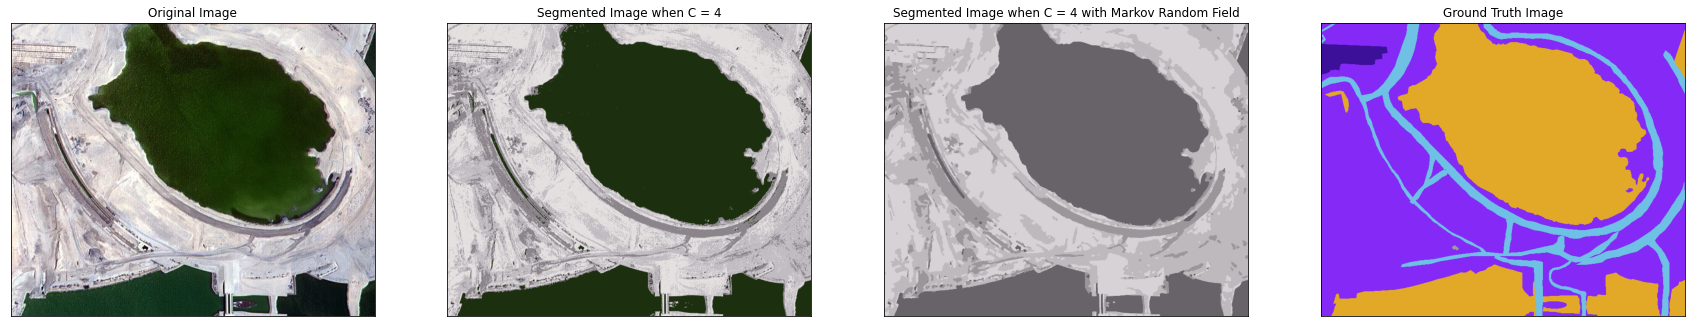

Adjusted Rand Index: 0.553135002391163
Homogeneity Score: 0.6141369006045994
Completeness Score: 0.4841802180047005
V-Measure, harmonic mean of homogenity and completeness: 0.5414700970808455
Fowlkes-Mallows Score: 0.7160626777486695
_____________________________________________________________________


In [5]:
import numpy as np
import cv2
from sklearn import metrics
import matplotlib.pyplot as plt
image = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/small/images/image_part_005.jpg'
#image = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/images/98_chunck.tif'
mask = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/kaggle_dubai_dataset/small/masks/image_part_005.png'
#mask = '/content/drive/MyDrive/Computer Vision Project/Dataset/Semantic segmentation dataset/xytong_dataset/masks/98_chunck.tif'
original_image = cv2.imread(image)

img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
C = 4
fc = FCMeans(vectorized, C)
clust , centr, pc = fc.execute(vectorized)
print('Partition Coefficient on FCM: '+str(pc))
y_pred = clust.argmax(axis = 1)
center = np.uint8(centr)
res = center[y_pred.flatten()]
result_image = res.reshape((img.shape))
MFCM = ModifiedFCMeans(vectorized, C, center, result_image)
cl, cr, pc = MFCM.execute(vectorized)
y_pred = cl.argmax(axis = 1)
center = np.uint8(cr)
res = center[y_pred.flatten()]
result_image_mrf = res.reshape((img.shape))

#--------------------------------------------

gt_img = cv2.imread(mask)
gt_img=cv2.cvtColor(gt_img,cv2.COLOR_BGR2RGB)
labels_true = np.squeeze(cv2.cvtColor(gt_img,cv2.COLOR_BGR2GRAY).reshape((-1,1)))
labels_pred = y_pred
ars=metrics.adjusted_rand_score(labels_true, labels_pred)
vm = metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)
fms=metrics.fowlkes_mallows_score(labels_true, labels_pred)

#--------------------------------------------
figure_size = 30
print('Partition Coefficient on MFCM: '+str(pc))
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,4,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,2),plt.imshow(result_image)
plt.title('Segmented Image when C = %i' % C), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,3),plt.imshow(result_image_mrf)
plt.title('Segmented Image when C = %i with Markov Random Field' % C), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,4),plt.imshow(gt_img)
plt.title('Ground Truth Image'), plt.xticks([]), plt.yticks([])
plt.show()

print('Adjusted Rand Index: '+str(ars))
print('Homogeneity Score: '+str(vm[0]))
print('Completeness Score: '+str(vm[1]))
print('V-Measure, harmonic mean of homogenity and completeness: '+str(vm[2]))
print('Fowlkes-Mallows Score: '+str(fms))
print('_____________________________________________________________________')
